In [33]:
from pyomo.environ import *
import sys
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [5]:
%%capture

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [6]:
!apt-get install -y -qq glpk-utils

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 120875 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

### Задание 1

Найти минимум функции $f=x_1+2x_2$ с помощью симплекс метода при ограничениях:

$3x_1 + 4x_2 >= 1$;

$2x_1 + 5x_2 >= 2$;

$x_1 >= 0$

$x_2 >= 0$

Использовать библиотеки Pyomo, pytopt, modobj

In [20]:
model = ConcreteModel()

model.x1 = Var(within=NonNegativeReals)
model.x2 = Var(within=NonNegativeReals)

# Целевая функция
model.obj = Objective(expr=model.x1 + 2*model.x2, sense=minimize)

# Ограничения
model.con1 = Constraint(expr=3*model.x1 + 4*model.x2 >= 1)
model.con2 = Constraint(expr=2*model.x1 + 5*model.x2 >= 2)

# Оптимизатор модуля glpk
solver = SolverFactory('glpk',executable='/usr/bin/glpsol')
results = solver.solve(model)

print(f"Минимум функции: {model.obj()}")
print(f"Значения переменных: \nx1 = {model.x1()}\nx2 = {model.x2()}")

Минимум функции: 0.8
Значения переменных: 
x1 = 0.0
x2 = 0.4


### Задание 2

In [82]:
m = 4
n = 5

a_data = {(i, j): np.random.uniform(1, 50) for i in range(1, n + 1) for j in range(1, m + 1)}
b_data = {i: np.random.uniform(1, 50) for i in range(1, n + 1)}
c_data = {j: np.random.uniform(1, 50) for j in range(1, m + 1)}

In [83]:
model = ConcreteModel()

# Размерности матриц
model.m = Param(initialize=m, within=NonNegativeIntegers)
model.n = Param(initialize=n, within=NonNegativeIntegers)

# Диапозоны индексов и ограничений
model.I = RangeSet(1, model.n)
model.J = RangeSet(1, model.m)

# Параметры
model.a = Param(model.I, model.J, initialize=a_data)
model.b = Param(model.I, initialize=b_data)
model.c = Param(model.J, initialize=c_data)

# Переменные
model.x = Var(model.J, domain=NonNegativeReals)

# Целевая функция
model.obj = Objective(rule=lambda model: sum(model.c[j] * model.x[j] for j in model.J))

# Ограничения
model.const = Constraint(model.I, rule=lambda model, i: sum(model.a[i, j] * model.x[j] for j in model.J) >= model.b[i])

solver = SolverFactory('clp')
solver.solve(model, tee=True)

print("Решение:")
for j in model.J:
    print(f"x[{j}] = {value(model.x[j])}")

print("Значение целевой функции:", value(model.obj))

Coin LP version 1.17.8, build Jun  7 2023
command line - /content/bin/clp /tmp/tmppceq20x6.pyomo.nl -AMPL 
CLP 1.17.8: Решение:
x[1] = 0.20885262475312186
x[2] = 0.0
x[3] = 0.0
x[4] = 0.7198624120472427
Значение целевой функции: 15.7871017359957


### Задание 3

Какое минимальное количество цветов нужно, чтобы покрасить каждую вершину так, чтобы соседние вершины были разных цветов?

G = (V, E)

C = {1, ... , k}

E - матрица смежности, X - матрица раскраски графа

min y

сумма x v,c = 1

x v,c + xv2,c <= 1
y >= c*x v,c

для любых v, принадлежащих V и c, принадлежащих C

X v,c принадлежит {0;1}

In [94]:
def generate_random_graph(V:int,E:int) -> nx.graph:
  if E > V * (V - 1) // 2:
    raise ValueError("Количество ребер не может превышать V*(V-1)/2 для V вершин.")

  G = nx.Graph()
  while G.number_of_edges() < E:
    u, v = np.random.choice(range(V), 2)
    if not G.has_edge(u, v) and u != v:
        G.add_edge(u, v)

  return G

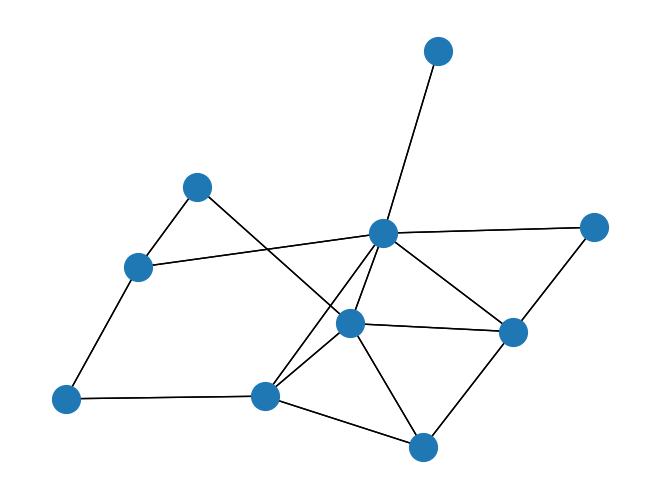

In [95]:
# Количество вершин
V = 10
# Количество ребер
E = 16

G = generate_random_graph(V, E)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=400)

connect={}
coordinate = {}
nodes = []
for edge in G.edges:
    connect[edge[0]+1,edge[1]+1]=1
    nodes.append(edge[0]+1)
    nodes.append(edge[1]+1)
nodes= list(set(nodes))
for n in G.nodes:
    coordinate[n+1,'X']=pos[n][0]
    coordinate[n+1,'Y']=pos[n][1]
nx.draw(G, pos)

In [96]:
adjacency_matrix = nx.adjacency_matrix(G)
E = adjacency_matrix.toarray()
print(f'Матрица смежности графа: \n{E}')

Матрица смежности графа: 
[[0 1 1 0 1 1 0 1 0 1]
 [1 0 1 0 0 1 1 0 0 0]
 [1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0]
 [1 0 0 1 0 0 0 0 1 0]
 [1 1 0 1 0 0 1 1 0 0]
 [0 1 0 0 0 1 0 1 0 0]
 [1 0 0 0 0 1 1 0 1 0]
 [0 0 0 0 1 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0]]


In [97]:
k = 5
N=len(G.nodes)

model = AbstractModel()

# Диапозоны индексов и ограничений
model.c = RangeSet(5)
model.i = RangeSet(N)
model.j = Set(initialize=model.i)

# Переменные
model.U = Var(model.i,model.c, within=Binary)
model.Y = Var(model.c, bounds=(0,1), within=Reals)

# Ограничениея
model.const1 = Constraint(model.i, rule=lambda model, i: sum(model.U[i,c] for c in model.c) == 1)

def c2(model, i, j, c):
    if (i, j) in connect:
        return model.U[i,c]+model.U[j,c]<= 1
    else:
        return Constraint.Skip

model.const2 = Constraint(model.i, model.j, model.c, rule=c2)
model.const3 = Constraint(model.i, model.c, rule=lambda model, i, c: model.U[i,c]<= model.Y[c])

# Целевая функция
model.obj = Objective(rule=lambda model: sum(model.Y[c] for c in model.c), sense=minimize)

solver = SolverFactory('glpk', executable='/usr/bin/glpsol')
instance = model.create_instance()
results = solver.solve(instance)

if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('Выполнено')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('Не выполнено')
else:
    print ('Solver Status:',  results.solver.status)

print(f'Минимальное количество цветов {value(instance.obj)}')

Выполнено
Минимальное количество цветов 3.0
